In [1]:
import utils as utils
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%autosave 120

Autosaving every 120 seconds


In [2]:
# Set up paths

path_process = '/Users/cezhang/Documents/deepzoom/00134'
path_raw = '/Users/cezhang/Documents/deepzoom/00134/00006.ARW'
path2_raw = '/Users/cezhang/Documents/deepzoom/00134/00002.ARW'

tar_rgb_path = '/Users/cezhang/Documents/deepzoom/00134/00002.JPG'
src_rgb_path = '/Users/cezhang/Documents/deepzoom/00134/00006.JPG'
ref_rgb_path = '/Users/cezhang/Documents/deepzoom/00134/00001.JPG'

tform_txt = '/Users/cezhang/Documents/deepzoom/00134/tform.txt'

up_ratio = 4

In [3]:
# Read in focal length and compute ratios

focal1 = utils.readFocal_pil(path_raw)
focal2 = utils.readFocal_pil(path2_raw)
focal_ref = utils.readFocal_pil(ref_rgb_path)

ratio = focal2/focal1
ratio_ref1 = focal_ref/focal1
ratio_ref2 = focal_ref/focal2
ratio_offset = ratio/up_ratio  # because the captured images do not follow exact zoom factors

print(ratio_ref1, ratio_ref2, ratio, ratio_offset)

6.857142857142857 1.5286624203821657 4.485714285714286 1.1214285714285714


In [4]:
# read in input raw, will be used as input raw
input_raw = utils.get_bayer(path_raw, black_lv = 512, white_lv = 16383)
input_raw = utils.reshape_raw(input_raw)
input_raw_orig = utils.crop_fov(input_raw, 1./ratio_ref1)

# read in target rgb image, will be used as ground truth
tar_rgb = np.array(Image.open(tar_rgb_path))
cropped_tar_rgb = utils.crop_fov(tar_rgb, 1./ratio_ref2)
tar_rgb_orig = utils.image_float(cropped_tar_rgb)

# read in input rgb image for visualization (make sure the alignment is correct)
src_rgb = np.array(Image.open(src_rgb_path))
cropped_input_rgb = utils.crop_fov(src_rgb, 1./ratio_ref1)
input_rgb_orig = utils.image_float(cropped_input_rgb)

# read in alignment matrices, will be used to align the target image to source 
# (because we don't want to transform or sample the raw sensor)
src_tform, src_tform_corner = utils.read_tform(tform_txt, key=os.path.basename(path_raw).split('.')[0])
tar_tform, _ = utils.read_tform(tform_txt, key=os.path.basename(path2_raw).split('.')[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image pair (target RGB and input RAW): (1544, 2448, 3) (193, 306, 4)


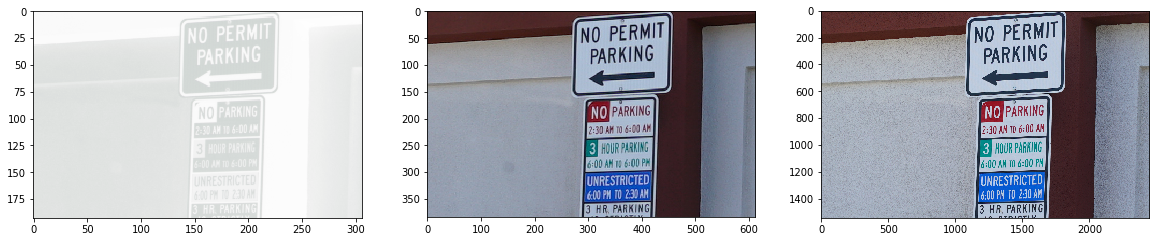

In [5]:
# To prepare paired images, we want to align the target rgb to the predicted rgb (from input raw),
# so we transform target image to align with the input using pre-computed transformation matrices

# we have to do a series of transformations in order to use the pre-computed transformation matrices
# in other word, to transfrom the target to the version where the transformation was computed.

# (alternatively we can compute transformation on-the-fly, but that might slow down training)

# tform.txt store transformation with respect to the reference image (00001.JPG)
# assuming input is 00006.RAW and target is 00002.JPG
# we want to get the transformation t(26) from target (00002.JPG) to source (00006.RAW)
# We know transfomration from 00002 --> 00001 (t21) and 00006 --> 00001 (t61)
# t26 = inv(t61) * t21:
tform = utils.concat_tform([
    np.append(tar_tform,[[0,0,1]],0),
    np.append(cv2.invertAffineTransform(src_tform),[[0,0,1]],0)])


# now we have to transform the target image to the right state to apply tform
# we first scale the target image to reference
tar_temp1 = cv2.resize(tar_rgb_orig, None, fx=ratio_ref2, fy=ratio_ref2, interpolation=cv2.INTER_CUBIC)
tar_temp2, transformed_corner = utils.post_process_rgb(
    tar_temp1,
    (tar_temp1.shape[0], tar_temp1.shape[1]),
    tform[0:2,...])
tar_temp3 = cv2.resize(tar_temp2, None, fx=1/ratio_ref2, fy=1/ratio_ref2, interpolation=cv2.INTER_CUBIC)
# now we have aligned the target to the input

# because we warpped the target image, we have to remove the black pixels accordingly for input raw and input rgb
input_raw = input_raw_orig[
    int(transformed_corner['minh']/(2*ratio_ref1)):int(transformed_corner['maxh']/(2*ratio_ref1)),
    int(transformed_corner['minw']/(2*ratio_ref1)):int(transformed_corner['maxw']/(2*ratio_ref1)), :]

input_rgb = input_rgb_orig[
    int(transformed_corner['minh']/ratio_ref1):int(transformed_corner['maxh']/ratio_ref1),
    int(transformed_corner['minw']/ratio_ref1):int(transformed_corner['maxw']/ratio_ref1)]

# we have to scale it by a ratio offset to match our desired zoom factor (e.g. 4X)
tarc, tarw = input_raw.shape[0] * up_ratio * 2, input_raw.shape[1] * up_ratio * 2
target_rgb = cv2.resize(tar_temp3, (tarw, tarc), interpolation=cv2.INTER_CUBIC)

# Now target_rgb should be 8X the spatial resolution of input RAW
print('Image pair (target RGB and input RAW):', target_rgb.shape, input_raw.shape)

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(input_raw)  # visualization raw to verify alignment
plt.subplot(1,3,2)
plt.imshow(input_rgb)
plt.subplot(1,3,3)
plt.imshow(target_rgb)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


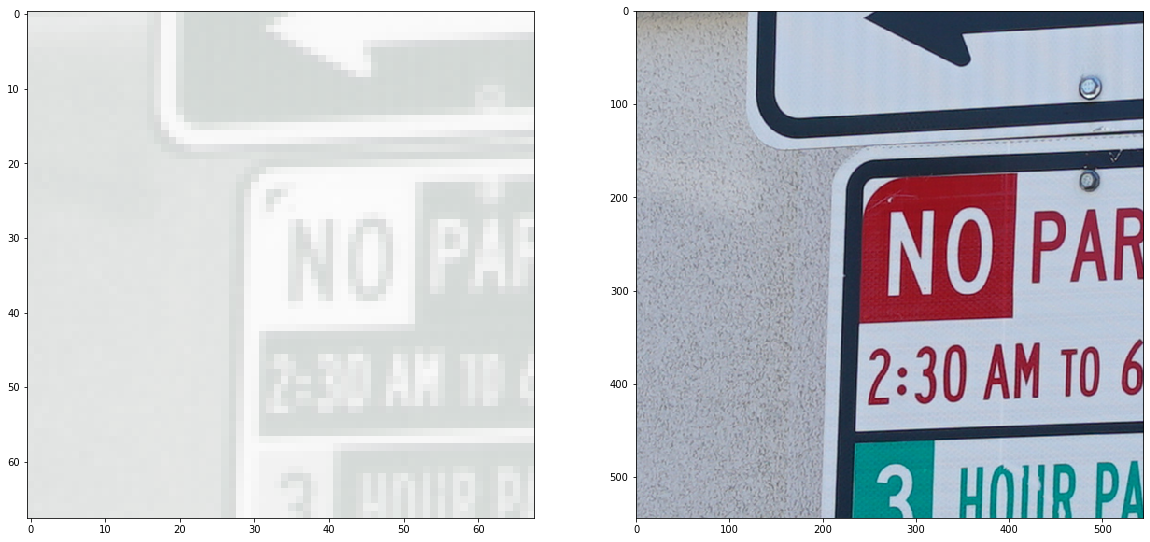

In [9]:
# for training, we crop patches from the aligned image pairs
patch_sz = 512
tol = 16  # if we want to consider boundary issue (not computing loss on boundary pixels)
raw_tol = int(tol / (up_ratio*2))  # corresponding boundary for raw

cropped_raw, cropped_rgb = utils.crop_pair(
    input_raw, target_rgb,
    croph=patch_sz, cropw=patch_sz,
    tol=tol, raw_tol=raw_tol,
    ratio=up_ratio,
    type='fixed',
    fixx=0.5, fixy=0.5)  
# cropping type can be either 'fixed' (then fixx and fixy are required) 
# or 'central' (central patch, equi. to setting fixx and fixy to 0.5, 0.5)
# or 'uniform' (patch position randomly drawn from a uniform distribution)

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(cropped_raw)  # visualization raw to verify alignment
plt.subplot(1,2,2)
plt.imshow(cropped_rgb)
plt.show()
